# Shopback Merchant Clicks Analysis
**Chew Jia Ler**

* [**Introduction**](#introduction)
* [**Objectives**](#objective)
* [**Definition of available datasets**](#definition)
* [**Importing libraries and data**](#import)
* [**Data Preprocessing and Exploration**](#preprocessing)
* [**Building model**](#model)
* [**Conclusion**](#conclusion)

<a id='introduction'></a>

# Introduction

## Background

ShopBack is a leading Cashback site that powers smarter purchase decisions for consumers, having presence in nine countries including Singapore, Australia, Taiwan, Malaysia, Indonesia, Philippines, Thailand, Vietnam and South Korea.

### How Shopback works?

ShopBack acts as a gateway for online merchants, where Shopback would earn a commission for each purchase made via ShopBack, and that commission amount is given back to the customers in a form of Cashback. This creates a smarter community of online shoppers, where they can save more on online spending.

## The business question

### <span style="color:red"> We would like to increase the customer clicks and customer click-through rate (CTR) on our merchants listing by showing merchants that are likely of their interest. How do we maximize the CTR on our merchants listing? </span>

### <ins>**How does this help Shopback?**<ins>
* Maximizing merchants' CTR means maximizing the chance of customers making a purchase, hence maximizing Shopback's commision and helps expand the business
* The code can be implemented by Shopback as a recommendation system that suggests  merchant(s) for users on all platforms
* The analysis can give Shopback insight information on the reasons that motivates merchant clicks, maximizing ROI on marketing spendings

<a id='objective'></a>
# Objective

## 1. Exploratory data analysis

The first step is exploring the dataset to derive findings and visualizing them in a clear manner.

## 2. Model building

Second step is to build a prediction model that predicts the next merchant that a user would click.

## 3. Model serving

The final step is to encapsulate the final model in the form of a web service.

<a id='definition'></a>
# Definition of available datasets

The available datasets are:

### Clicks

| Column Name  | Description |
| :------------ | :------------ |
| id | Click Identifier |
| user_id  | User Identifier  |
| store_id  | Store Identifier  |
| device  | User Device |
| platform | Platform that user makes the click from |
| channel | Channel that contributes the click |
| created_at | Timestamp of the click is made |

### Stores

| Column Name  | Description |
| :------------ | :------------ |
| id  | Store Identifier  |
| merchant_id | Corresponding merchant identifier for the store |
| start_at | Store Start Date |
| end_at | Store End Date |
| display_text | Text Displayed for the Store |
| is_searchable | Where Store is Searchable from App |

*  Multiple stores might map to the same merchant

### Users

| Column Name  | Description |
| :------------ | :------------ |
| id  | User Identifier  |
| signup_datetime | Timestamp of User Sign Up |
| lifetime_first_merchant | The first merchant that user purchase with Shopback |
| lifetime_first_purchase_datetime | Datetime of first purchase |
| account_referral | Referral of the account, usually refers to campaigns |

<a id='import'></a>
# Importing libraries and data

## Libraries and settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ppscore as pps
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

from pathlib import Path
import os
from utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Importing datasets

In [3]:
cwd = Path.cwd()
clickspath = os.path.join(cwd, 'data/clicks.parquet')
storespath = os.path.join(cwd, 'data/stores.parquet')
userspath = os.path.join(cwd, 'data/users.parquet')

In [4]:
clicks = pd.read_parquet(clickspath, engine='pyarrow')
stores = pd.read_parquet(storespath, engine='pyarrow')
users = pd.read_parquet(userspath, engine='pyarrow')

<a id='preprocessing'></a>
# Data preprocessing and exploration

## Preprocessing - Users

In [5]:
# Checking data types and sparsity in users data
print(users.dtypes)
print()
print(users.isna().sum()/len(users))

id                                    int64
signup_datetime                      object
lifetime_first_merchant_id          float64
lifetime_first_purchase_datetime     object
account_referral                     object
dtype: object

id                                  0.000000
signup_datetime                     0.000000
lifetime_first_merchant_id          0.620433
lifetime_first_purchase_datetime    0.617974
account_referral                    0.000000
dtype: float64


In [6]:
# Check if 'lifetime_first_merchant_id' column contains all integers except NaN
(users['lifetime_first_merchant_id'].fillna(-9999) % 1  == 0).all()

True

In [7]:
# Convert columns to appropriate datatypes
users['lifetime_first_merchant_id'] = users['lifetime_first_merchant_id'].apply(lambda x: "{:.0f}".
                                          format(x) if not pd.isna(x) else None)
users['signup_datetime'] = pd.to_datetime(users['signup_datetime'])
users['lifetime_first_purchase_datetime'] = pd.to_datetime(users['lifetime_first_purchase_datetime'])

# Break down datetime data into date and time
users['signup_date'] = users['signup_datetime'].dt.date
users['signup_time'] = users['signup_datetime'].dt.time
users['signup_yearmonth'] = users['signup_datetime'].dt.strftime('%Y-%m')

## Preprocessing - Clicks

In [8]:
# Checking data types and sparsity in clicks data
print(clicks.dtypes)
print()
print(clicks.isna().sum()/len(clicks))

index          int64
id             int64
user_id        int64
store_id       int64
device        object
platform      object
channel       object
created_at    object
dtype: object

index         0.000000
id            0.000000
user_id       0.000000
store_id      0.000000
device        0.000192
platform      0.000000
channel       0.000192
created_at    0.000000
dtype: float64


In [9]:
# Convert columns to appropriate datatypes
clicks['created_at'] = pd.to_datetime(clicks['created_at'])
clicks['store_id'] = clicks['store_id'].apply(str)

# Extract date from datetime data
clicks['created_date'] = clicks['created_at'].dt.date
clicks['created_year'] = clicks['created_at'].dt.year
clicks['created_time'] = clicks['created_at'].dt.time
clicks['created_hour'] = clicks['created_at'].dt.hour
clicks['created_dayofweek'] = clicks['created_at'].dt.day_name()
clicks['created_dayofweek'] = pd.Categorical(clicks['created_dayofweek'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' , 'Saturday', 'Sunday'],
                                   ordered=True)
clicks['created_dayofweeknum'] = clicks['created_at'].dt.dayofweek

# Rename 'id' column for clarity
clicks.rename(columns = {'id':'click_id'}, inplace = True)

In [10]:
# Minor data error in 'clicks' table, where there is year 2048. Might want to check the source

print(clicks['created_year'].value_counts())
clicks.loc[clicks['created_year']==2048]

2021    1846145
2048         10
Name: created_year, dtype: int64


,index,click_id,user_id,store_id,device,platform,channel,created_at,created_date,created_year,created_time,created_hour,created_dayofweek,created_dayofweeknum
70625,966794,1729579,102709,182,app_android,Android App,paid_ins_organic,2048-08-11 11:03:17,2048-08-11,2048,11:03:17,11,Tuesday,1
523976,1496569,1537199,42826,233,app_ios,iOS App,paid_ins_organic,2048-08-02 09:16:46,2048-08-02,2048,09:16:46,9,Sunday,6
793219,1581293,33385,177858,36,extension,Browser Extension,Extension,2048-05-20 19:29:56,2048-05-20,2048,19:29:56,19,Wednesday,2
807839,785400,310615,215099,424,app_android,Android App,paid_rtg_googleadwords_int,2048-06-03 00:15:59,2048-06-03,2048,00:15:59,0,Wednesday,2
1077423,34020,829004,3021,331,app_android,Android App,paid_ins_organic,2048-06-25 23:45:35,2048-06-25,2048,23:45:35,23,Thursday,3
1137607,1783029,1226143,54655,284,app_android,Android App,paid_ins_naver,2048-07-13 21:44:09,2048-07-13,2048,21:44:09,21,Monday,0
1307762,604201,702419,77881,316,extension,Browser Extension,Extension,2048-06-20 17:56:08,2048-06-20,2048,17:56:08,17,Saturday,5
1484619,954542,1428288,94995,424,app_android,Android App,paid_ins_organic,2048-07-25 23:43:00,2048-07-25,2048,23:43:00,23,Saturday,5
1487850,741481,119414,108435,331,app_android,Android App,paid_ins_organic,2048-05-25 05:29:48,2048-05-25,2048,05:29:48,5,Monday,0
1831475,1315394,1676075,195293,182,app_android,Android App,Direct,2048-08-06 06:57:37,2048-08-06,2048,06:57:37,6,Thursday,3


In [11]:
# remove clicks data where year is 2048
clicks = clicks[clicks['created_year']!=2048]

## Preprocessing - Stores

In [12]:
# Checking data types and sparsity in stores data
print(stores.dtypes)
print()
print(stores.isna().sum()/len(stores))

id                 int64
merchant_id        int64
start_at          object
end_at            object
display_text      object
is_searchable    float64
dtype: object

id               0.000000
merchant_id      0.000000
start_at         0.368715
end_at           0.368715
display_text     0.368715
is_searchable    0.471136
dtype: float64


In [13]:
# Convert columns to appropriate datatypes
stores['id'] = stores['id'].apply(str)
stores['merchant_id'] = stores['merchant_id'].apply(str)

## Preprocessing and Feature Engineering - Overall

In [14]:
# Most recent user signup date is later than most recent click date. This means population of users that signed up after more recent click date will not have click data recorded
most_recent_clickdatetime = max(clicks['created_at'])
most_recent_signup = max(users['signup_datetime'])
print('The most recent click happened at : ' + str(most_recent_clickdatetime))
print('The most recent signup happened at : ' + str(most_recent_signup))

# Creating two new columns for 'users':
# 1. 'click_count' : Total number of clicks made by user
# 2. 'average_weekly_click_count' : Average number of clicks made by user, starting from signup date
users['click_count'] = users['id'].map(clicks['user_id'].value_counts())
users['click_count'] = users['click_count'].fillna(0)
users['click_count'] = users['click_count'].astype(int)
users['average_weekly_click_count'] = users['click_count']/((most_recent_clickdatetime-users['signup_datetime']).dt.days + 1)*7

# Create a new dataframe that only contain users before most recent click. This is to allow comparisons to be made in same context
users_before_maxclickdate = users.loc[users['signup_datetime']<=max(clicks['created_at'])]

# Creating three new columns for 'clicks':
# 1. 'first_click_in_2021' : If this click is the first merchant click by user in 2021
# 2. 'time_diff_since_last_click_current_year' : Time difference between current click and previous click of user. If first click, value will be NaN
# 3. 'time_diff_since_last_click_current_year_in_minutes' : Time difference (in minutes) between current click and previous click of user. If first click, value will be NaN
clicks = clicks.sort_values(['user_id','created_at'], ascending=True)
clicks['first_click_in_2021'] = clicks.duplicated(['user_id'])==False
clicks['time_diff_since_last_click_current_year'] = clicks.groupby('user_id')['created_at'].diff(1) 
clicks['time_diff_since_last_click_current_year_in_minutes'] = clicks['time_diff_since_last_click_current_year'] / np.timedelta64(1, 'm')

The most recent click happened at : 2021-03-31 00:00:00
The most recent signup happened at : 2021-05-06 01:27:39.962000


In [15]:
# Joining all tables
mergedclicks = clicks.merge(stores,how='left',left_on=['store_id'],right_on=['id']).merge(users,how='left',left_on=['user_id'],right_on=['id'])
mergedclicks.drop(['id_x', 'id_y'], axis = 1,inplace=True)

# Creating 2 new column for joined table
# 1. 'most_clicked_merchant_id' : merchant_id most clicked by user
# 2. 'click_count_most_clicked_merchant_id' : number of clicks by user of most clicked merchant

df_newcolumns = mergedclicks.groupby([mergedclicks['user_id'], mergedclicks['merchant_id']]).size().sort_values().groupby(level=0).tail(1).reset_index(name='click_count_most_clicked_merchant_id')
df_newcolumns = df_newcolumns.rename(columns={"merchant_id": "most_clicked_merchant_id"})
mergedclicks = mergedclicks.merge(df_newcolumns,how='left',left_on=['user_id'],right_on=['user_id'])
pd.set_option('display.max_columns', None)
mergedclicks

,index,click_id,user_id,store_id,device,platform,channel,created_at,created_date,created_year,created_time,created_hour,created_dayofweek,created_dayofweeknum,first_click_in_2021,time_diff_since_last_click_current_year,time_diff_since_last_click_current_year_in_minutes,merchant_id,start_at,end_at,display_text,is_searchable,signup_datetime,lifetime_first_merchant_id,lifetime_first_purchase_datetime,account_referral,signup_date,signup_time,signup_yearmonth,click_count,average_weekly_click_count,most_clicked_merchant_id,click_count_most_clicked_merchant_id
0,1315237,1646293,0,182,app_android,Android App,paid_ins_organic,2021-03-20 14:16:34,2021-03-20,2021,14:16:34,14,Saturday,5,True,NaT,NaN,40,None,None,None,NaN,2021-03-20 14:15:59.392,None,NaT,partnership,2021-03-20,14:15:59.392000,2021-03,1,0.636364,40,1
1,1360840,1048577,1,74,desktop,Web,Paid Search,2021-02-19 19:10:57,2021-02-19,2021,19:10:57,19,Friday,4,True,NaT,NaN,74,2021-04-30 15:00:00,2021-05-31 14:59:59,2.5% 캐시백,1.0,2020-05-05 13:57:03.195,12251,2020-05-05 15:06:05,ebbonus5,2020-05-05,13:57:03.195000,2020-05,11,0.233333,399,5
2,1360841,1052326,1,74,desktop,Web,Paid Search,2021-02-19 19:17:44,2021-02-19,2021,19:17:44,19,Friday,4,False,0 days 00:06:47,6.783333,74,2021-04-30 15:00:00,2021-05-31 14:59:59,2.5% 캐시백,1.0,2020-05-05 13:57:03.195,12251,2020-05-05 15:06:05,ebbonus5,2020-05-05,13:57:03.195000,2020-05,11,0.233333,399,5
3,1360839,1038003,1,74,desktop,Web,Paid Search,2021-02-19 19:18:25,2021-02-19,2021,19:18:25,19,Friday,4,False,0 days 00:00:41,0.683333,74,2021-04-30 15:00:00,2021-05-31 14:59:59,2.5% 캐시백,1.0,2020-05-05 13:57:03.195,12251,2020-05-05 15:06:05,ebbonus5,2020-05-05,13:57:03.195000,2020-05,11,0.233333,399,5
4,1360845,1432849,1,425,desktop,Web,Paid Search,2021-03-11 18:31:04,2021-03-11,2021,18:31:04,18,Thursday,3,False,19 days 23:12:39,28752.650000,399,2020-11-17 15:00:00,2050-12-31 14:59:59,최대 1.0% 캐시백,1.0,2020-05-05 13:57:03.195,12251,2020-05-05 15:06:05,ebbonus5,2020-05-05,13:57:03.195000,2020-05,11,0.233333,399,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846140,963900,1675320,250442,437,app_android,Android App,paid_ins_organic,2021-03-22 14:43:30,2021-03-22,2021,14:43:30,14,Monday,0,False,5 days 01:24:18,7284.300000,302,None,None,None,NaN,2020-08-24 09:41:15.391,22709,2020-11-19 07:27:11,shinhan6000,2020-08-24,09:41:15.391000,2020-08,58,1.853881,490,18
1846141,963899,1669991,250442,437,app_android,Android App,paid_ins_organic,2021-03-22 17:40:14,2021-03-22,2021,17:40:14,17,Monday,0,False,0 days 02:56:44,176.733333,302,None,None,None,NaN,2020-08-24 09:41:15.391,22709,2020-11-19 07:27:11,shinhan6000,2020-08-24,09:41:15.391000,2020-08,58,1.853881,490,18
1846142,963901,1682046,250442,437,app_android,Android App,paid_ins_organic,2021-03-23 19:31:18,2021-03-23,2021,19:31:18,19,Tuesday,1,False,1 days 01:51:04,1551.066667,302,None,None,None,NaN,2020-08-24 09:41:15.391,22709,2020-11-19 07:27:11,shinhan6000,2020-08-24,09:41:15.391000,2020-08,58,1.853881,490,18
1846143,963868,1732447,250442,182,app_android,Android App,paid_ins_organic,2021-03-26 16:53:36,2021-03-26,2021,16:53:36,16,Friday,4,False,2 days 21:22:18,4162.300000,40,None,None,None,NaN,2020-08-24 09:41:15.391,22709,2020-11-19 07:27:11,shinhan6000,2020-08-24,09:41:15.391000,2020-08,58,1.853881,490,18


## Exploration strategy

The formula for merchant click is:

> Number of merchant click = Number of users * Merchant clicks per users

Hence we can optimize merchant clicks by:

1. Increasing number of users (preferably active users)
2. Increasing number of merchant clicks of users

The proceeding analysis below will be focused on answering the two optimization targets above.

## Exploration - Users

#### Question: How did our users join us?

* Based on `account_referral` column, there are 71 distinct referral methods. We want to look at which of those are the most effective ones. Did the new users signed up organically or via ads/referral?

Fraction of users covered by top 4 joining methods:
93.26%

Earliest user signup date: 2020-02-05
Most recent user signup date: 2021-05-06


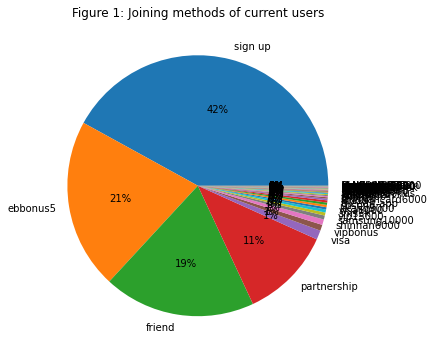

In [16]:
# Analyzing 'account_referral' column of all users

print('Fraction of users covered by top 4 joining methods:')
print("{:.2f}".format(users['account_referral'].value_counts(normalize=True)[:4].sum()*100)+"%")
print()
print('Earliest user signup date: ' + str(min(users['signup_date'])))
print('Most recent user signup date: ' + str(max(users['signup_date'])))

referral_valcounts = users['account_referral'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(referral_valcounts.values, labels=referral_valcounts.index, autopct='%1.0f%%')
plt.title('Figure 1: Joining methods of current users')
plt.show()

#### Observations:

* Top 4 joining methods account for 93% of users.
* 58% of users were from ads/referral. Since more than half of new users are not organic signups, this gives us an impression that the ads/referral campaigns are working.

#### Notes:

* However the signup date of these users span from Feb 2020 to May 2021. The spread of joining methods might not be uniform across the entire signup span.

To understand the users better, next we look at **users growth rate**.

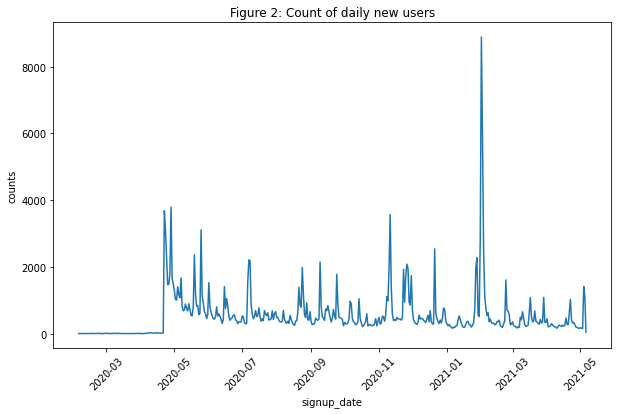

In [17]:
# Group up users by signup date
users_bysignupdate = users.groupby('signup_date').size().reset_index(name='counts')
users_bysignupdate.set_index('signup_date',inplace=True)

# Plot graph of daily new users
plt.figure(figsize=(10, 6))
sns.lineplot(x='signup_date',y='counts',data=users_bysignupdate)
plt.xticks(rotation=45)
plt.title('Figure 2: Count of daily new users')
plt.show()

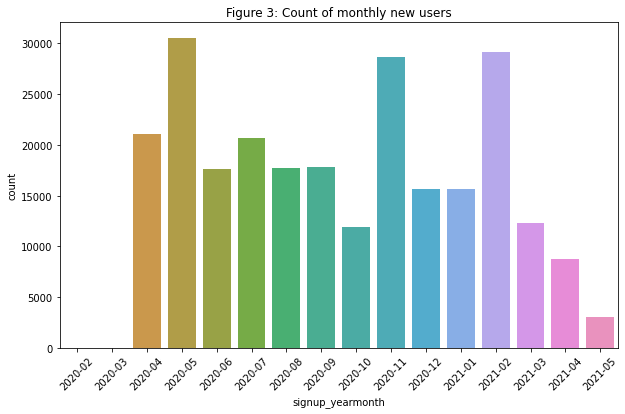

In [18]:
# Plot graph of monthly new users
plt.figure(figsize=(10, 6))
sns.countplot(x='signup_yearmonth',data=users,order=sorted(users['signup_yearmonth'].unique()))
plt.xticks(rotation=45)
plt.title('Figure 3: Count of monthly new users')
plt.show()

#### Observations:

* From monthly new users counts, new users in the recent three months have been declining.
* From daily new user count, there is an unusual spike between Jan 2021 and Mar 2021. This spike is not reflected in the monthly graph, making it even more worthwhile to be investigated.

#### Notes:

* Next, let's view users growth rate from a cumulative point of view. Perhaps we can see the effect of the spike indicated in daily new user count.

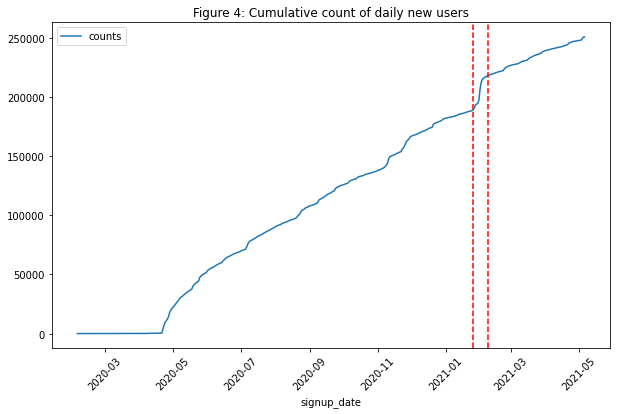

In [19]:
# Plot graph of cumulative daily new users
users_bysignupdate.sort_index().cumsum().plot(figsize=(10, 6))
plt.xticks(rotation=45)
plt.axvline('2021-01-26', color='red', linestyle='--')
plt.axvline('2021-02-08', color='red', linestyle='--')
plt.title('Figure 4: Cumulative count of daily new users')
plt.show()

In [20]:
# Calculating growth rate increase during spike
spiked_users = users.loc[(users['signup_datetime'] >= '2021-01-26') & (users['signup_datetime'] <= '2021-02-08')]
users_growth_during_spike = len(spiked_users)/((spiked_users.signup_datetime.max() - spiked_users.signup_datetime.min()).days + 1)
users_before_spike = users.loc[(users['signup_datetime'] >= '2020-07-01') & (users['signup_datetime'] <= '2021-01-25')]
average_growth_before_spike = len(users_before_spike)/((users_before_spike.signup_datetime.max() - users_before_spike.signup_datetime.min()).days + 1)
print('Growth rate increase during Jan 26, 2021 to Feb 8, 2021 is '+"{:.2f}".format(users_growth_during_spike/average_growth_before_spike)+'x!')
print(str(len(spiked_users))+' new users by during the two weeks!')

Growth rate increase during Jan 26, 2021 to Feb 8, 2021 is 3.92x!
29158 new users by during the two weeks!


#### Observations:

* The effect of spike in daily new user is highlighted in the cumulative new user graph.
* The spike resulted in 29,158 new users accross a span of two weeks, from Jan 26, 2021 to Feb 8, 2021.
* The growth rate in during the spike was almost four times (3.92x) of the average growth rate for the five months prior.

#### Notes:

* What was the reason for the spike? Was there a successful campaign?
* Next, look into the joining methods for the new users during the spike

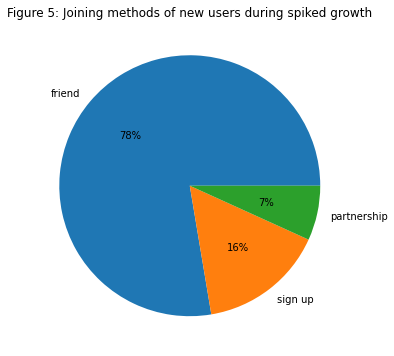

In [21]:
# Analyzing 'account_referral' column for new users during the spike

spiked_referral_valcounts = spiked_users['account_referral'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(spiked_referral_valcounts.values, labels=spiked_referral_valcounts.index, autopct='%1.0f%%')
plt.title('Figure 5: Joining methods of new users during spiked growth')
plt.show()

#### Observations:

* 78% the new users during the spike was due to friends, leading the others by a huge margin.
* The distribution of joining methods is very unlike the overall pattern in Figure 1, where 'friend' only accounts for 19% of the overall joining methods.

#### Notes:

* Two possibilities for the spike:
    1. A marketing/promotional campaign that happened during the two weeks that involves referral and rewards.
    2. An extremely popular merchant launched a campaign/promotion on Shopback.
* Since we have no data on Shopback marketing campaigns, we can look at what merchant did the new users first clicked on.

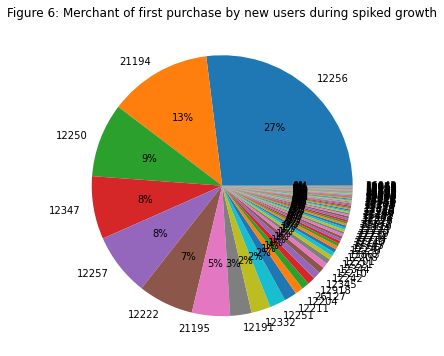

91.21% of the new users during spike period have never made any purchase


In [22]:
# Analyzing 'lifetime_first_merchant_id' of new users during the spike

spiked_referral_valcounts = spiked_users['lifetime_first_merchant_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(spiked_referral_valcounts.values, labels=spiked_referral_valcounts.index, autopct='%1.0f%%')
plt.title('Figure 6: Merchant of first purchase by new users during spiked growth')
plt.show()
print("{:.2f}".format(spiked_users['lifetime_first_merchant_id'].isna().sum()/len(spiked_users)*100)+'% of the new users during spike period have never made any purchase')

#### Observations:

* 91% of the new users that joined during the growth spike did not make any purchase.
* Among those who clicked on at least made one purchase, there is no obvious pattern in the clicks.

#### Notes:

* Since there is unlikely a merchant that attracted this group of new users, it is most likely that there was a promotional campaign that attracted a large group of new users.
* However, the campaign failed to translate the new users to purchases.

## Exploration - Clicks

#### Question: Who are the users that are clicking on the merchants? Are there any commonalities among them?

* This question is important for Shopback South Korea to better understand the actual users (instead of ghost users). This allows more customized and targetting campaigns to different groups of users.

The first analysis is to view the portion of our users who have clicked at least one merchant

In [23]:
percentage_user_with_0_clicks = "{:.2f}".format((users_before_maxclickdate['click_count']==0).sum()/len(users_before_maxclickdate)*100)
print(percentage_user_with_0_clicks + "% of all users have never clicked on any merchant")

56.44% of all users have never clicked on any merchant


#### Observations:

* Around half (56%) of the users are considered 'ghost users' who have not clicked on any merchant

#### Notes:

* Now that we have a sense of what population made at least one click, the next analysis is to view daily clicks across the different platforms and devices

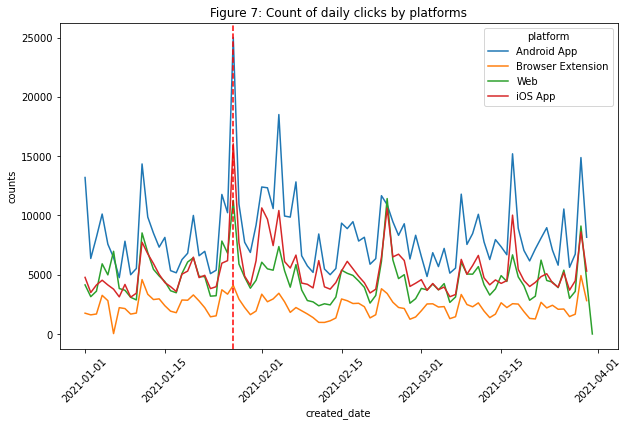

In [24]:
# Analyzing daily clicks via platform and device

clicks_byplatformdaily = clicks.groupby([clicks['created_date'], clicks['platform']]).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.lineplot(x='created_date',y='counts',data=clicks_byplatformdaily, hue='platform')
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime('2021-01-27'), color='red', linestyle='--')
plt.title('Figure 7: Count of daily clicks by platforms')
plt.show()

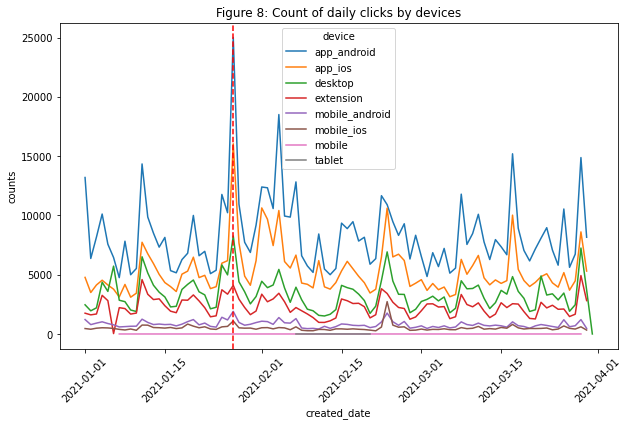

In [25]:
clicks_bydevicedaily = clicks.groupby([clicks['created_date'], clicks['device']]).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.lineplot(x='created_date',y='counts',data=clicks_bydevicedaily, hue='device')
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime('2021-01-27'), color='red', linestyle='--')
plt.title('Figure 8: Count of daily clicks by devices')
plt.show()

#### Observations:

* Daily clicks via platform/device is pretty normal. Androids leading the charge via app clicks.
* Most of the users access the merchants via mobile app, be it Android or Apple users.

#### Notes:

* Since there is nothing much to be concluded, zoom into day of week instead, hopefully can look for strategic days to push ads/notification

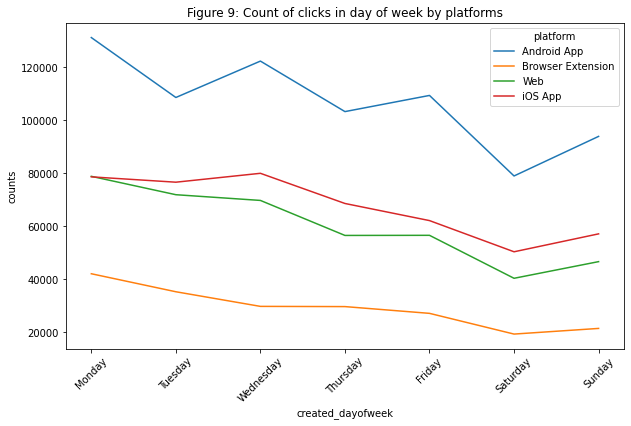

In [26]:
# Analyzing clicks by day of week and platform and device

clicks_byplatformdayofweek = clicks.groupby([clicks['created_dayofweek'], clicks['platform']]).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.lineplot(x='created_dayofweek',y='counts',data=clicks_byplatformdayofweek, hue='platform')
plt.xticks(rotation=45)
plt.title('Figure 9: Count of clicks in day of week by platforms')
plt.show()

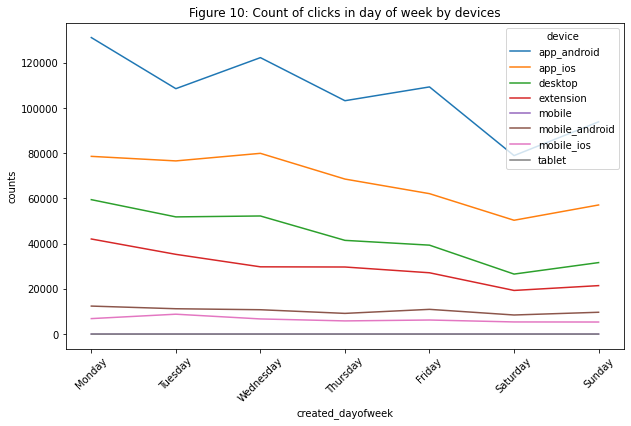

In [27]:
clicks_bydevicedayofweek = clicks.groupby([clicks['created_dayofweek'], clicks['device']]).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.lineplot(x='created_dayofweek',y='counts',data=clicks_bydevicedayofweek, hue='device')
plt.xticks(rotation=45)
plt.title('Figure 10: Count of clicks in day of week by devices')
plt.show()

#### Observations:

* Contrary to expectations, clicks are most active on Mondays, and pattern is consistent among all platform/device

#### Notes:

* There is noticable difference in the amount of clicks occuring at the beginning of the week as compared to weekends.
* In general, there is a gradual decline in clicks as the week progresses.
* To pinpoint on the most popular clicking period, we need to zoom into time of the click as well

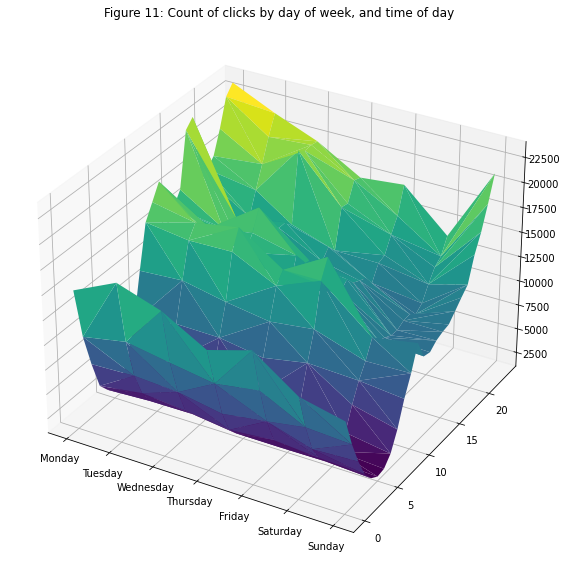

In [28]:
# Analyzing heatmap of clicks in day of week and time

clicks_bydayofweek_bytime = clicks.groupby([clicks['created_dayofweeknum'], clicks['created_hour']]).size().reset_index(name='counts')
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(clicks_bydayofweek_bytime['created_dayofweeknum'], clicks_bydayofweek_bytime['created_hour'], clicks_bydayofweek_bytime['counts'], cmap=plt.cm.viridis, linewidth=0.2)
days_of_week = clicks['created_dayofweek'].sort_values().unique()
ax.set(xticks=range(len(days_of_week)),xticklabels=days_of_week)
plt.title('Figure 11: Count of clicks by day of week, and time of day')
plt.show()

#### Observations:

* Users are more actively clicking at the later half of the day, with the maximum after 9 PM

#### Notes:

* Overall best time for campaigns/promotion that requires quick user response (example: flash sales) can be done at Monday nights

Another important direction to analyse is the **channels** that the clicks came from. This would measure Shopback South Korea's presence on the available access channels.

Fraction of clicks covered by top 3 channels:
79.24%

Earliest click date: 2021-01-01 00:00:15
Most recent click date: 2021-03-31 00:00:00

A total of 55 unique channels


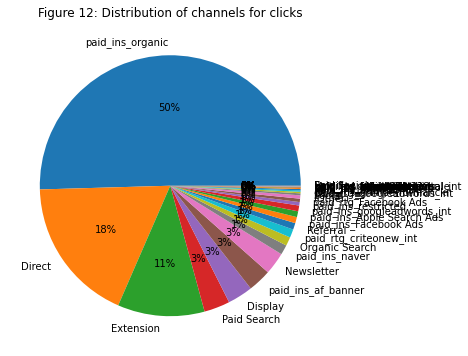

In [29]:
# Analyzing channels that clicks originate from

print('Fraction of clicks covered by top 3 channels:')
print("{:.2f}".format(clicks['channel'].value_counts(normalize=True)[:3].sum()*100)+"%")
print()
print('Earliest click date: ' + str(min(clicks['created_at'])))
print('Most recent click date: ' + str(max(clicks['created_at'])))
print()
print('A total of ' + str(clicks['channel'].nunique()) + ' unique channels')

channel_valcounts = clicks['channel'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(channel_valcounts.values, labels=channel_valcounts.index, autopct='%1.0f%%')
plt.title('Figure 12: Distribution of channels for clicks')
plt.show()

#### Observations:

* Top 3 channels account for 79% of clicks.

#### Notes:

* This could mean that Shopback South Korea's presence is only strong is certain access channels.
* Shopback South Korea can now launch/promote new campaigns at the popular channels, and work on increasing market share at the other channels.
* For next improvement, the suggestion would be to group up channels into more meaningful buckets, as 55 of them might be too many for meaningful analysis.
* Next, we look at the daily clicks of the top 3 channel accross these three months

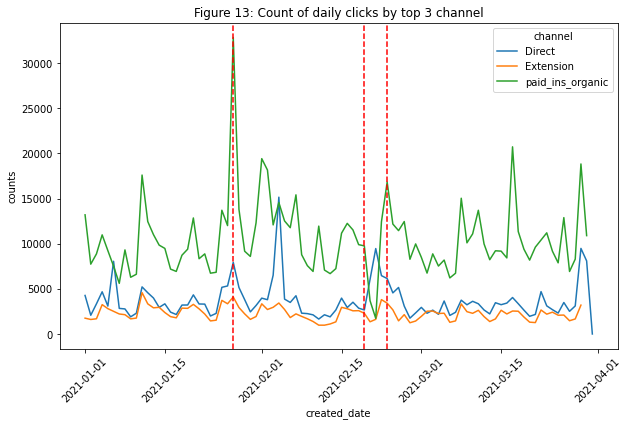

In [30]:
# Analyzing daily clicks of top 3 channels

clicks_bychanneldaily = clicks.groupby([clicks['created_date'], clicks['channel']]).size().reset_index(name='counts')
clicks_bychanneldaily = clicks_bychanneldaily.loc[clicks_bychanneldaily['channel'].isin(['paid_ins_organic','Direct','Extension'])]
plt.figure(figsize=(10, 6))
sns.lineplot(x='created_date',y='counts',data=clicks_bychanneldaily, hue='channel')
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime('2021-02-19'), color='red', linestyle='--')
plt.axvline(pd.to_datetime('2021-02-23'), color='red', linestyle='--')
plt.axvline(pd.to_datetime('2021-01-27'), color='red', linestyle='--')
plt.title('Figure 13: Count of daily clicks by top 3 channel')
plt.show()

#### Observations:

* There was a significant spike in clicks on Jan 27 across all three channels.
* Between Feb 19, 2021 and Feb 23, 2021, the number of clicks from `Direct` overtook `paid_ins_organic` due to steep decline is `Direct` clicks, and spike in `paid_ins_organic` at the same time.

#### Notes:

* It would be useful to see what motivated the clicks on Jan 27.
* Also, it would be interesting to investigate if the simultaneous decline/spike of `paid_ins_organic` and `Direct` channels between Feb 19, 2021 and Feb 23, 2021 was coincidence, or there was a reason for it.

To understand if there are any relations between merchants and channels, next we look at the **top merchants and top channels**

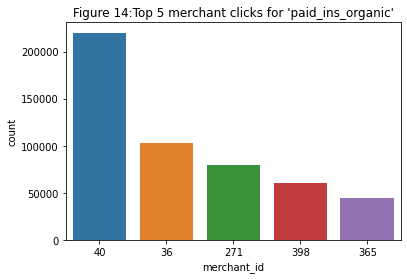

The 5 merchants sum up to 54.44% of clicks from paid_ins_organic



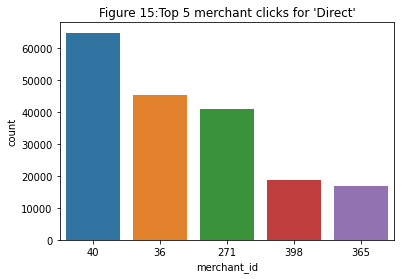

The 5 merchants sum up to 56.19% of clicks from Direct



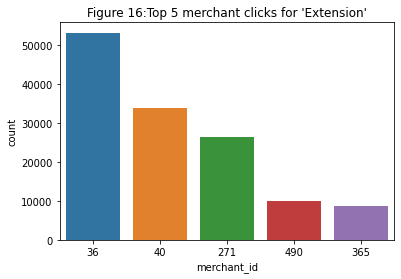

The 5 merchants sum up to 66.58% of clicks from Extension

There are a total of 388 uniquely clicked merchants


In [31]:
# Analyze the top merchant clicks for top 3 channels

# Increment count for plot figure
n=14
for channel in ['paid_ins_organic','Direct','Extension']:
    channelclicks = mergedclicks.loc[mergedclicks['channel']==channel]
    percentage = "{:.2f}".format(channelclicks['merchant_id'].value_counts(normalize=True)[:5].sum()*100)
    sns.countplot(x='merchant_id',data=channelclicks, order=channelclicks['merchant_id'].value_counts()[:5].index)
    plt.title('Figure '+ str(n)+':Top 5 merchant clicks for \'' + channel + '\'')
    n+=1
    plt.show()
    print('The 5 merchants sum up to '+percentage+'% of clicks from '+channel+'\n')

print('There are a total of ' + str(mergedclicks['merchant_id'].nunique()) + ' uniquely clicked merchants')

#### Observations:

* The merchants from top 3 channels are also the top shopback merchants, with the exception of merchant `490` replacing `398`'s spot in `Extension` channel.
* The top 5 merchants from each of the top channels occupies more than half of the total clicks of the channel.

#### Notes:

* Initial observation suggests that clicks from different channel would always lead toward the common merchants. This could be bad for Shopback South Korea because it would mean that Shopback South Korea's revenue is mainly dependent on a minority of merchants.
* This increases Shopback South Korea's revenue fluctuation risks as high-profile merchant leaves the platform, or suffers reputation damage.

Next, we look at the **activeness of users** brought in by the top `account_referral` methods. We want to answer the question:

>Among users with at least 1 click, what are the average weekly click counts for top `account_referrals`?

We excluded users with 0 clicks because some users might be ghost accounts that are no longer used

In [32]:
# Among users with at least 1 click, what are the average weekly click counts for top account_referrals? (exclude 0 clicks because some might be ghost accounts that are no longer used)

print('Table 1: Statistical description of average weekly clicks of users with at least 1 click')
users_before_maxclickdate_withclicks = users_before_maxclickdate.loc[users_before_maxclickdate['click_count']>0]
users_before_maxclickdate_withclicks.groupby('account_referral')['average_weekly_click_count'].describe().sort_values(by='count', ascending = False)[:5]

Table 1: Statistical description of average weekly clicks of users with at least 1 click


,count,mean,std,min,25%,50%,75%,max
account_referral,,,,,,,,
sign up,36646.0,1.500060,4.974748,0.016667,0.158401,0.424242,1.217391,385.000000
ebbonus5,27929.0,0.606629,1.124259,0.020408,0.102639,0.273913,0.695906,58.489796
friend,22044.0,1.571107,4.884595,0.020408,0.142676,0.402878,1.228485,210.000000
partnership,11426.0,2.223412,4.794699,0.033019,0.246479,0.736842,2.216017,112.000000
vipbonus,1158.0,0.543840,0.824989,0.022581,0.090323,0.248387,0.658659,10.161290


#### Observations:

* Among top account_referrals that brought in the most users, users that joined from `partnership` (4th referral) had the highest mean and medium weekly click count compared to other users, followed by `friend` (3rd referral) and `sign up` (top referral)


#### Notes:

* If Shopback South Korea wants to promote a campaign to increase their users, their best bet is to aim for `partnership` and `friend` referrals.

#### Question: How active are our users? What are they looking for?

* This question is important to understand what are our users looking for, and what are their objectives. For example:

    * Are they here to browse around?
    * Are they waiting for a particular merchant/store to offer more cashback?

First, we look at the time gap between user clicks.

Median time difference between clicks : 22.30 minutes


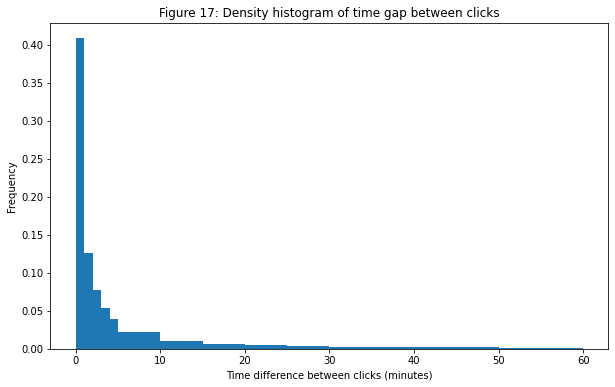

In [33]:
# Analyze time gaps between clicks

df_plot =  clicks[(clicks['first_click_in_2021']==False)]['time_diff_since_last_click_current_year_in_minutes']
ax = df_plot.plot.hist(bins=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], density=True, figsize=(10,6))
print("Median time difference between clicks : {0:1,.2f} minutes".format(np.median(df_plot)))
ax.set_xlabel("Time difference between clicks (minutes)")
plt.title('Figure 17: Density histogram of time gap between clicks')
plt.show()

#### Observations:

* To measure the average time difference, we use Median instead of Mean because there are significant amount of anomalies.
* To median time difference between clicks is 22 minutes.

#### Notes:

* A time gap of 22 minutes seems pretty long for a users who are browsing around in the app. This information is a possible indicator that users are here to 'camp', or wait for cashback offers from their preferred merchant.

Next, we try to verify if users are using Shopback to look for cashback from their preferred merchant. We do this by measuring their *loyalty*. The *loyalty* of a user can be defined as:

> (Number of clicks for the most frequently visited merchant of the user) / (Total clicks of the user)

A 100% on this measure would mean that this user only clicks on this one merchant; where a low value would mean that this user is hopping around merchants.

Number of users with two clicks and above: 87401
Number of users : 238319
Median loyalty : 53.33%
Mean loyalty : 60.02%


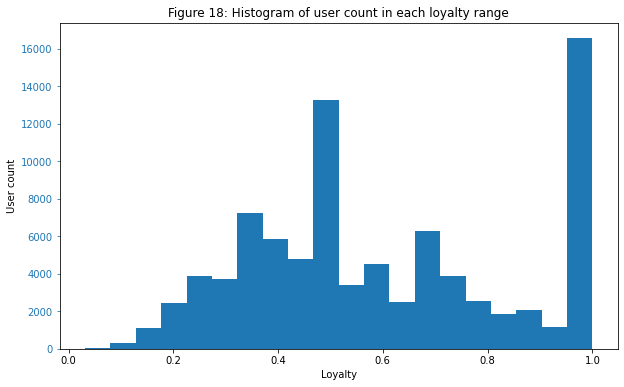

In [34]:
# Select users that have performed two clicks and above
mergedclicks_users = mergedclicks[['user_id','click_count','most_clicked_merchant_id','click_count_most_clicked_merchant_id']].drop_duplicates()
mergedclicks_revisitors = mergedclicks_users[mergedclicks_users['click_count']>1]

# Calculate users' loyalty score
mergedclicks_revisitors['loyalty'] = mergedclicks_revisitors['click_count_most_clicked_merchant_id']/mergedclicks_revisitors['click_count']

# Calculating median and mean loyalty
print('Number of users with two clicks and above: ' + str(len(mergedclicks_revisitors)))
print('Number of users : ' + str(len(users_before_maxclickdate)))
print("Median loyalty : {0:1,.2f}%".format(np.median(mergedclicks_revisitors['loyalty'])*100))
print("Mean loyalty : {0:1,.2f}%".format(np.mean(mergedclicks_revisitors['loyalty'])*100))

# Plotting the loyalty graph
fig, ax = plt.subplots()
df_plot = mergedclicks_revisitors['loyalty']
ax = df_plot.plot.hist(figsize=(10,6), color='C0',bins=20)
ax.tick_params(axis='y', colors='C0')
ax.set_xlabel('Loyalty', fontsize=10)
ax.set_ylabel('User count', fontsize=10)
plt.title('Figure 18: Histogram of user count in each loyalty range')
plt.show()

#### Observations:

* Among 238,319 users, only 87,401 of them (37%) have made two clicks and above.
* The average loyalty value is between 50%-60%, this means that general users have half the chance to revisit the same merchant.


#### Notes:

* Since the data is from Jan 2021 to Mar 2021, and given the population of internet users in South Korea, there is still a lot of market share to be captured by Shopback South Korea.
* For active users, it seems like around half of the time they are looking at the same merchant. As mentioned in the notes after Figure 15, this could mean that Shopback South Korea is highly dependant of the top-performing merchants.

<a id='datasummary'></a>
## Summary

1. A recent spike of 29,158 new users over the course of two weeks (4x growth rate) suggests that referral from friends might be a good way to get people into Shopback South Korea. However, the campaign serves as a reminder to make sure the new users translates into clicks/purchases.


2. The most active days in Shopback South Korea are Mondays, and slowly declines until the weekend. The most active hours are at night after 9 PM. Overall best time for campaigns/promotion that requires quick user response (example: flash sales) can be done at Monday nights


3. Top 3 channels account for 79% of clicks. This could mean that Shopback South Korea's presence is only strong is certain access channels.
* Shopback South Korea can now launch/promote new campaigns at the popular channels, and work on increasing market share at the other channels.
* For next improvement, the suggestion would be to group up channels into more meaningful buckets, as 55 of them might be too many for meaningful analysis.


4. Shopback South Korea's revenue is mainly dependent on the top few merchants. This increases Shopback South Korea's revenue fluctuation risks as high-profile merchant leaves the platform, or suffers reputation damage. This statement in inferred from the following observations:

    * Clicks from different channel would always lead toward the common merchants.
    * Active users (more than 2 merchant clicks) have a loyalty measure of 50%-60%. This means that general users have half the chance to revisit the same merchant. 
    * Relatively long time gap between clicks (22 minutes). The assumption here is this time gap is slightly long for a user who is browsing multiple merchants. This resembles more to a scenario where a user is waiting for a deal in a merchant.


5. Users that joined `partnership`, `friend` and `sign up` have the highest number of average weekly clicks, among the popular user joining methods. from If Shopback South Korea wants to promote a campaign to increase their users, their best bet is to aim for these three channels.



### Suggestions / Next Steps:

1. The referral channel is frequently used in this analysis, however there are too many unique values. It can be improved by categorizing them into fewer, meaningful buckets.


2. Categorizing merchants by the nature of their business would be useful to indicate the users' areas of interest. It will likely be a very insightful information.

<a id='model'></a>
# Building model

The model aims to predict the next merchant that a user would click. Since we are predicting merchants, we will not be including merchant data into the picture.

Even though we can use information such as cashback rate, however due to sparsity of merchant data and for the sake of simplicity, we will be excluding them.

## Selecting columns

In [35]:
# From the merged table, select columns that are likely to be relevant for prediction, and label 'merchant_id'
mergedclicks_simplified = mergedclicks[['device','platform','channel','created_hour','created_dayofweek','first_click_in_2021','time_diff_since_last_click_current_year_in_minutes','lifetime_first_merchant_id','account_referral','click_count','average_weekly_click_count','most_clicked_merchant_id','click_count_most_clicked_merchant_id','merchant_id']]

## Predictive Power Analysis (PPS) for correlation analysis

In [36]:
print('Table 2: PPS of all columns on user next merchant click')
pps.predictors(mergedclicks_simplified,'merchant_id')

Table 2: PPS of all columns on user next merchant click


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,most_clicked_merchant_id,merchant_id,0.439502,classification,True,weighted F1,0.0776,0.482997,DecisionTreeClassifier()
1,lifetime_first_merchant_id,merchant_id,0.209450,classification,True,weighted F1,0.0850,0.276646,DecisionTreeClassifier()
2,click_count_most_clicked_merchant_id,merchant_id,0.050802,classification,True,weighted F1,0.0776,0.124460,DecisionTreeClassifier()
3,click_count,merchant_id,0.044163,classification,True,weighted F1,0.0776,0.118336,DecisionTreeClassifier()
4,average_weekly_click_count,merchant_id,0.040603,classification,True,weighted F1,0.0776,0.115052,DecisionTreeClassifier()
5,channel,merchant_id,0.036754,classification,True,weighted F1,0.0800,0.113814,DecisionTreeClassifier()
6,device,merchant_id,0.033913,classification,True,weighted F1,0.0800,0.111200,DecisionTreeClassifier()
7,platform,merchant_id,0.024042,classification,True,weighted F1,0.0776,0.099776,DecisionTreeClassifier()
8,time_diff_since_last_click_current_year_in_min...,merchant_id,0.014360,classification,True,weighted F1,0.0862,0.099322,DecisionTreeClassifier()
9,created_hour,merchant_id,0.012056,classification,True,weighted F1,0.0776,0.088720,DecisionTreeClassifier()


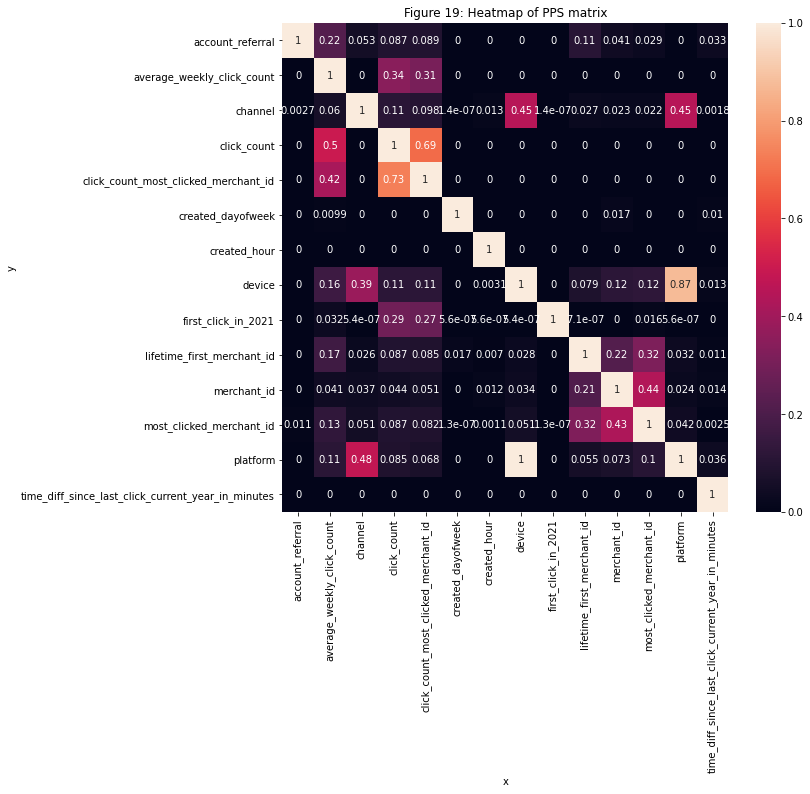

In [37]:
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(pps.matrix(mergedclicks_simplified).pivot(columns='x', index='y', values='ppscore'),annot=True)
plt.title('Figure 19: Heatmap of PPS matrix')
plt.show()

**PPS suggests that `most_clicked_merchant_id` and `lifetime_first_merchant_id` are the most important features in predicting users' merchant click.**

Altogether, the scores don't look very promising, although that's to be expected given the sheer amount of 388 distinct merchants. This suggests that a more appropriate strategy would be to build a taxonomy (eg: merchant category) and do a stacked/multi-tier classification. Nonetheless, only trial-and-error can prove which is the better method.

For simplicities sakes, we will do a simple classification task using XGBoost.

## Preprocessing dataset to be trained and tested

In [38]:
# Label Encode datasets using LabelEncoder
mergedclicks_simplified_encoded = mergedclicks_simplified.copy()
encode_columns = ['device','platform','channel','created_dayofweek','first_click_in_2021','lifetime_first_merchant_id','account_referral','most_clicked_merchant_id','merchant_id']
le_dic = {}
for col in encode_columns:
    le = LabelEncoder()
    le.fit(mergedclicks_simplified_encoded[col])
    mergedclicks_simplified_encoded[col] = le.fit_transform(mergedclicks_simplified_encoded[col])
    le_dic[col] = le
    
# Splitting data into features and labels
mergedclicks_simplified_features = mergedclicks_simplified_encoded.copy()
mergedclicks_simplified_labels = mergedclicks_simplified_features.pop('merchant_id')

# Generating training, evaluation and test set in 70:10:20 ratio. Random seed = 88
x, x_test, y, y_test = train_test_split(mergedclicks_simplified_features, mergedclicks_simplified_labels, test_size=0.2, random_state = 88)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.125, random_state = 88)

# Preparing train and test set into XGBoost formats
D_train = xgb.DMatrix(x_train, label=y_train)
D_val = xgb.DMatrix(x_val, label=y_val)
D_test = xgb.DMatrix(x_test, label=y_test)

## Training model : XGBoost

### Setting up hyperparameters

In [39]:
# Setting up parameters for XGBoost model
param = {
    'eta': 0.05,
    'max_depth': 3,  
    'objective': 'multi:softprob',
    'eval_metric': ['mlogloss','merror'],
    'num_class': mergedclicks_simplified_labels.nunique()} 

steps = 30
features = list(mergedclicks_simplified_features.columns)

### Training and evaluating model

Training model...
[0]	val-mlogloss:3.48016	val-merror:0.47983	train-mlogloss:3.48432	train-merror:0.48078
[5]	val-mlogloss:3.06434	val-merror:0.47637	train-mlogloss:3.06760	train-merror:0.47723
[10]	val-mlogloss:2.86867	val-merror:0.47524	train-mlogloss:2.87117	train-merror:0.47601
[15]	val-mlogloss:2.73741	val-merror:0.47496	train-mlogloss:2.73950	train-merror:0.47574
[20]	val-mlogloss:2.63929	val-merror:0.47458	train-mlogloss:2.64098	train-merror:0.47533
[25]	val-mlogloss:2.56346	val-merror:0.47428	train-mlogloss:2.56458	train-merror:0.47500
[29]	val-mlogloss:2.51360	val-merror:0.47397	train-mlogloss:2.51458	train-merror:0.47470
Training done!


-- Model Report --
Accuracy: 0.5247881396098356
F1-Score (Macro): 0.14650437748559786
Precision: 0.21473845277079592
Recall: 0.1269189077717937

Classification Report:

              precision    recall  f1-score   support

           0       0.28      0.18      0.22        28
           1       0.47      0.23      0.31        73
          10

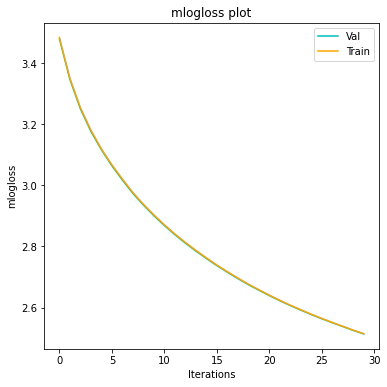

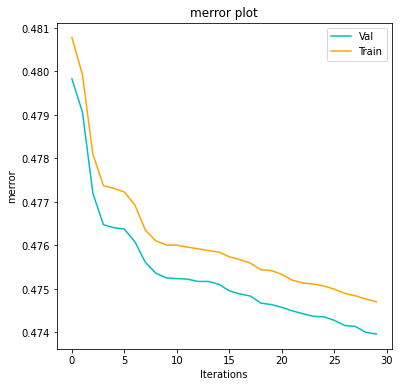

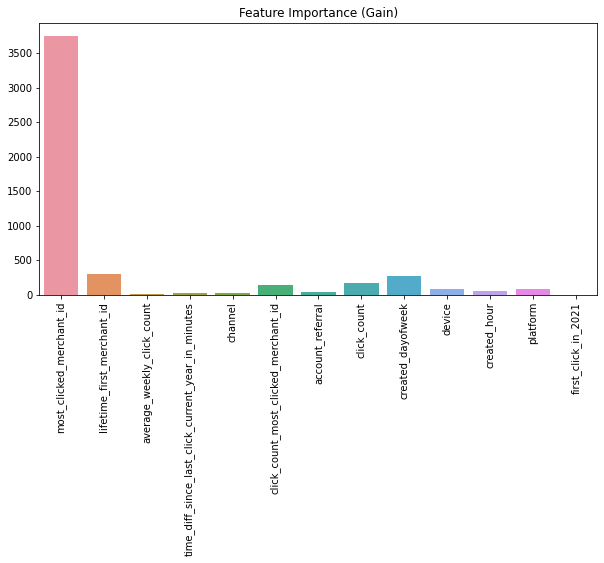

In [40]:
# Train and evaluate the model
model = fitXgb(param, steps, D_train, D_val, D_test, y_test, features, le_dic)

#### Observations:

1. After 30 iterations, model has accuracy of 52.5% and macro F1 score of 14.65%
2. Training loss is still relatively high after 30 iterations.
3. Accuracy gain has reached diminishing returns starting at 10th iteration.
4. Feature importance of `most_clicked_merchant_id` leads other features by a huge margin, follwed by `lifetime_first_merchant_id` and `created_dayofweek` This is aligned with the observation on Predictive Power Score evaluation.

#### Notes:

1. It's pretty difficult to interpret to precision/recall/F1 score of individual classes because there's too many of them.
2. Confusion matrix was not plotted for the same reason.

### Saving model and encoding mapping for serving model

In [41]:
# Save model to JSON
model.save_model('model/model.json')
# Save to text format
model.save_model('model/model.txt')

In [42]:
# Saving LabelEncoder dict
output = open('model/encoding/le_dic.pkl', 'wb')
pickle.dump(le_dic, output)
output.close()

# Saving unique values for prediction web services
for col, lex in le_dic.items():
    textfile = open("metadata/"+col+".txt", "w")
    for element in mergedclicks_simplified[col].unique():
        if element is None:
            textfile.write('(No value)\n')
        else:
            textfile.write(str(element) + "\n")
    textfile. close()

<a id='conclusion'></a>
# Conclusion

### Data

* Referral from friends is a good way to get people into Shopback South Korea. However this does not guarantee tranlation into clicks/purchases.
* The most active days in Shopback South Korea are Mondays, and slowly declines until the weekend. The most active hours are at night after 9 PM.
* Top 3 channels account for 79% of clicks.
* Shopback South Korea's revenue has high dependency on the top few merchants.
* Among the popular user joining methods, users that joined via partnership, friend and sign up have the highest number of average weekly clicks.

*Click [here](#datasummary) for detailed summary on data*

### Model

* Preliminary model suggests that user's historical merchant clicks/purchases plays a significant role in predicting their next click.

## Limitations and improvement

### Data

* Some columns such as `channel` and `merchant_id` are overly granular. These columns have high potential in gaining click insight, and improving accuracy of prediction.
* Data only consist of three months data. Would be useful to have data that spans across a longer period.

### Model

* Since data/sample size for each clicked merchant is highly unbalanced, need to customize loss function to penalize more on smaller merchant classes.
* Ensure that every merchant classes appear in training set.
* Increase number of training steps, then predict with additional paramter of `model.best_ntree_limit`.
* Optimize hyperparameters via iterations using **GridSearchCV**.
* Compare performance against other models, including ensemble models.